# Non-Negative Matrix Factorization for Image Compression and Clustering

This is the Python Jupyter Notebook for the Medium article on the from scratch implementation of the Non-Negative Matrix Factorization (NNMF) algorithm in Python. It illustrates the basic implementation of the algorithm and explores some of its features in the context of 
1. Image compression 
2. Clustering of neural signals.

As we will do the implementation of the NNMF algorithm ourselfs we will only import the basic Python libraries in the first step. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

A detailed explanation of the intuition behind the NNMF algorithm can be found in the accopmpaning Medium article to this notebook which is why we will keep this part short here. In brief, what we want to achiev in NNMF is to represent any positive, numerical matrix as the product of two lower dimensional matrices. This allows us to 1) reduce the size of an image file and 2) cluster datasets by their most prominent features. So what we want to do is the following: 

$$ V = WH$$

Where *V* is our original input matrix, e.g. an image, *W* is our feature matrix and *H* contains the weights of the features. This way we can reconstruct *V* from *WH*. 
The hard part however is to find *W* and *H*. There are several ways of doing so but here we will stay with the multiplicative update rule derived from the loss function based on the square of the Euclidian distance between *V* and *WH*. 

$$L(V, HW)={\lVert V-WH \rVert}^2$$

Using this this loss function will give rise to the following update rule for H and W:

$$H^{n+1}_{[i,j]} \leftarrow H^{n}_{[i,j]} \frac{((W^n)^T V))_{[i,j]}}{((W^n)^T W^n H^n)_{[i,j]}}$$
$$W^{n+1}_{[i,j]} \leftarrow W^{n}_{[i,j]} \frac{(V (H^{n+1})^T))_{[i,j]}}{(W^n H^{n+1} (H^{n+1})^T)_{[i,j]}}$$

If you want to understand this in more detail I recommend to look into the publication by [Lee and Seung](https://papers.nips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf).

As you can see from the above *H* and *W* are updated sequentially staring with *H*. The updated *H* is then used to update *W*.  
Translating the update rule from above into Python code we end up with the following two functions:

In [2]:
def update_H(W, H, V):
    numerator = W.T.dot(V)
    denominator = W.T.dot(W).dot(H) + 1e-10
    H = H*(numerator / denominator)
    return H

def update_W(W, H, V):
    numerator = V.dot(H.T)
    denominator = W.dot(H).dot(H.T) + 1e-10
    W = W*(numerator / denominator)
    return W

So now that we implemented the update rules for *H* and *W* we need to put them into context. This means we have to 1) initialize them and 2) update them in an iterative manner.  

The initialization will be done by chosing random positive numbers with matrix dimensions that will resemble the dimensions of the original input matrix *V* after the multiplication of *W* and *H*. Further we need to choose the second dimension for both matrices *W* and *H*. This is called the *rank* in NNMF and will determine the quality of the image compression or the number of clusters we will find in our dataset.  

The function below takes care of all the above. By default we run the algorithm for 100 iterations with a rank of 10. If this is the best default setting we will see later in this notebook. As we initialize *W* and *H* with random numbers our loss will be large in the beginning.

$$L(V, HW)=max(L(V, HW))$$

The loss is expected to decline with every iteration until it reaches a minimum . However, it should be noted here that this minimum does not have to be the global minimum but rather represents a local minimum. Therefore running the NNMF algorithm multiple times will avoid getting stuck in unfortunate, local minimum with a large error.

In [204]:
def do_nnmf(V, rank=10, iter=100):
    
    # Initialize 
    n, m = V.shape
    
    W = np.abs(np.random.randn(1, n, rank))[0]
    H = np.abs(np.random.randn(1, rank, m))[0]
    
    loss = []
    for i in range(iter):
        H = update_H(W, H, V)
        W = update_W(W, H, V)
        
        loss.append(sum((V - W.dot(H)).flatten()**2))

    return H, W, loss

OK, that is it. A simple, basic implementation of NNMF with Python from scratch.

Now let's load an image and see how we can use our NNMF function to compress it. We will load the image with [Matplotlib](https://matplotlib.org/) and then pick only one of the color channels to keep things simple.

In [323]:
img = plt.imread("./images/small.jpg")
V = img[:, :, 1] # only use one color channel

# Visualize the 

Alright so now that we loaded and prepared our image we can hand it over to our NNMF function. As mentioned above let's also increase the default values a little to see if they make sense.

In [327]:
H, W, loss = do_nnmf(V, rank=20, iter=300)

By default our NNMF function will also output the loss in each iteration. So before we look at the result in detail we should first check if the algorithm behaves as expected, meaning the loss decreases with every iteration and to verify our choise of default settings.

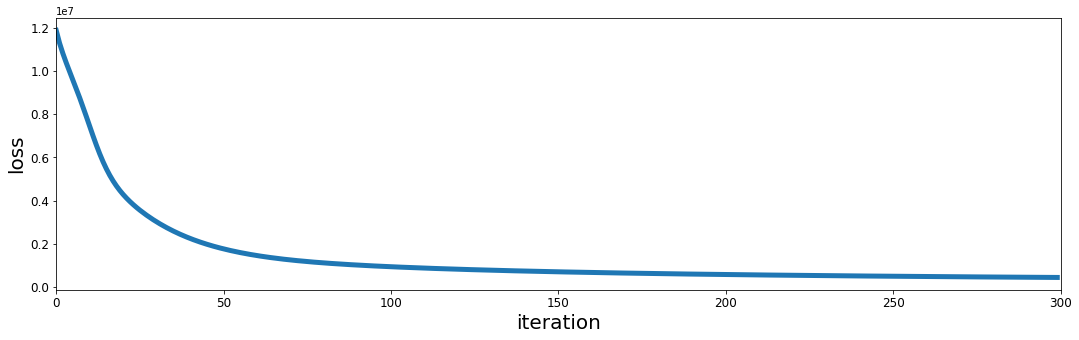

In [328]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(loss, lw=5)
ax.tick_params(labelsize=12)
ax.set_xlim(0, 300)
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('loss', fontsize=20)

plt.show()

Ok that looks good. The loss decreases with every iteration until it reaches a minimum. However going for only 100 iterations seems a bit tight as the loss still decreases after 100 iterations. So we better keep it at 300. 

Now the big question(s): How does the reconstructed image look like annd how does the choice of rank influences the result?  

Let's have a look!

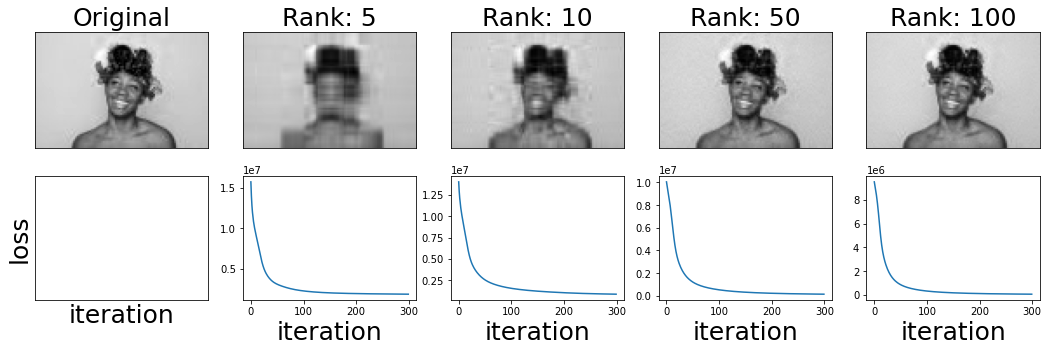

In [329]:
ranks_to_test = [5, 10, 50, 100]

n_plots = len(ranks_to_test) + 1
fig, ax = plt.subplots(2, n_plots, figsize=[18, 5])

# Plot original image as reference
ax[0][0].imshow(V, cmap='gray')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_title('Original', fontsize=25)

ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_xlabel('iteration', fontsize=25)
ax[1][0].set_ylabel('loss', fontsize=25)

data_points_original = V.shape[0] * V.shape[1]

data_points = []

n = 1
for i in ranks_to_test:
    
    H, W, loss = do_nnmf(V, rank=i, iter=300)
    
    # Reconstruct the image from W and H
    V_rec = W.dot(H)

    data_points.append((H.shape[0] * H.shape[1]) + (W.shape[0] * W.shape[1]))
    
    ax[0][n].imshow(V_rec, cmap='gray')
    ax[0][n].set_xticks([])
    ax[0][n].set_yticks([])
    ax[0][n].set_title('Rank: {}'.format(i), fontsize=25)
    
    ax[1][n].plot(loss)
    ax[1][n].set_xlabel('iteration', fontsize=25)

    n += 1
    
plt.show()

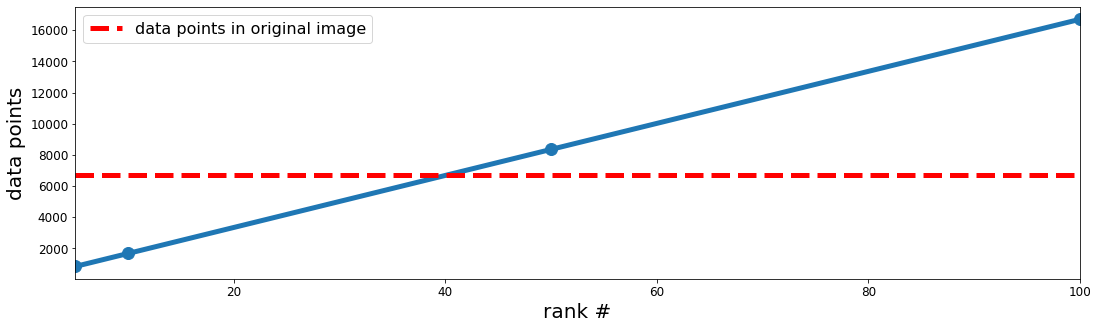

In [310]:
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

ax.plot(ranks_to_test, data_points, marker='o', lw=5, markersize=12)
ax.plot((ranks_to_test[0], ranks_to_test[-1]), 
        (data_points_original, data_points_original), 
        'r--', lw=5,
        label='data points in original image')

ax.tick_params(labelsize=12)
ax.set_xlim(ranks_to_test[0], ranks_to_test[-1])
ax.set_xlabel('rank #', fontsize=20)
ax.set_ylabel('data points', fontsize=20)
ax.legend(fontsize=16)

plt.show()

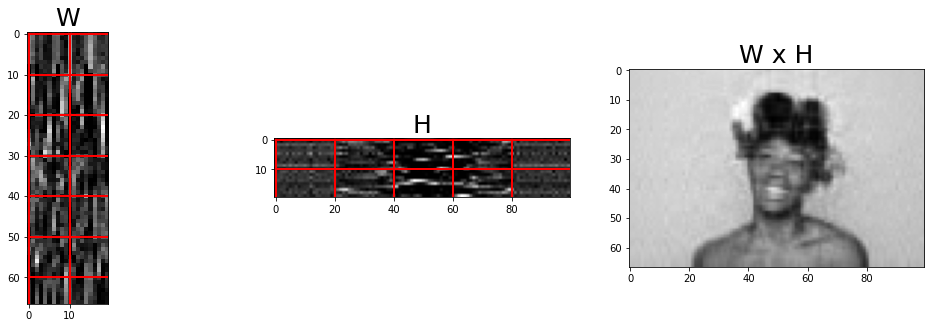

In [164]:
H, W, _ = do_nnmf(V, rank=20, iter=300)
V_rec = W.dot(H)

fig, ax = plt.subplots(1, 3, figsize=[18, 5])

ax[0].imshow(W, cmap='gray')
ax[0].grid(color='r', linestyle='-', linewidth=2)
ax[0].set_title('W', fontsize=25)

ax[1].imshow(H, cmap='gray')
ax[1].grid(color='r', linestyle='-', linewidth=2)
ax[1].set_title('H', fontsize=25)

ax[2].imshow(V_rec, cmap='gray')
ax[2].set_title('W x H', fontsize=25)

plt.show()

In [144]:
print(W.shape[0] * W.shape[1] + H.shape[0] * H.shape[1])
print(V.shape[0] * V.shape[1])

3340
6700


Dataset: https://www.kaggle.com/joseguzman/waveforms

In [243]:
data = pd.read_csv('./data/waveforms.csv')

label = data.iloc[:, 0]
organoid = data.iloc[:, -1]
data = data.iloc[:, 1:-1].to_numpy()
data = data.T + np.abs(np.min(data))

Notebook: https://www.kaggle.com/joseguzman/spike-classification-based-on-waveforms

Related: https://towardsdatascience.com/whos-talking-using-k-means-clustering-to-sort-neural-events-in-python-e7a8a76f316

In [318]:
n_rank = 3
H, W, loss = do_nnmf(data, rank=n_rank, iter=1000)

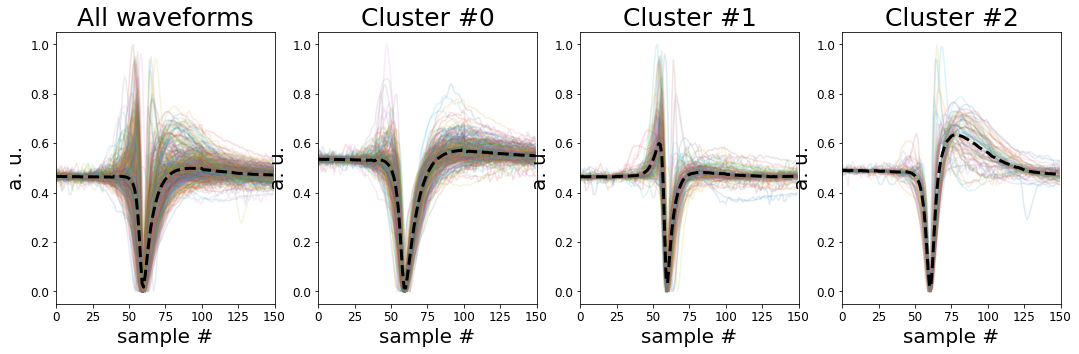

In [319]:
cluster_id = []
for x in range(H.shape[1]):
    cluster_id.append(np.where(np.max(H[:, x]) == H[:, x])[0][0])
    
fig, ax = plt.subplots(1, n_rank + 1, figsize=[18, 5])

all_waveforms = data / np.max(data)
mean_all_waveforms = np.mean(all_waveforms, axis=1)

ax[0].plot(all_waveforms, alpha=0.15)
ax[0].plot(mean_all_waveforms, color='black', linewidth=3, linestyle='dashed')
ax[0].set_title('All waveforms', fontsize=25)
ax[0].set_xlim(0, data.shape[0])
ax[0].set_xlabel('sample #', fontsize=20)
ax[0].set_ylabel('a. u.', fontsize=20)  
ax[0].tick_params(labelsize=12)


for cluster in range(n_rank):
    cluster_index = np.where([x == cluster for x in cluster_id])

    waveforms = data.T[cluster_index].T
    waveforms = waveforms / np.max(waveforms)
    mean_waveform = np.mean(waveforms, axis=1)

    ax[cluster + 1].plot(waveforms, alpha=0.15)
    ax[cluster + 1].plot(mean_waveform, color='black', linewidth=3, linestyle='dashed')
    ax[cluster + 1].set_title('Cluster #{}'.format(cluster), fontsize=25)
    ax[cluster + 1].set_xlim(0, waveforms.shape[0])
    ax[cluster + 1].set_xlabel('sample #', fontsize=20)
    ax[cluster + 1].set_ylabel('a. u.', fontsize=20)    
    ax[cluster + 1].tick_params(labelsize=12)
    
plt.show()